In [1]:
%%bash
pip install pytorch-pretrained-bert

In [3]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [4]:
# using default hyperparametere

class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [5]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 231508/231508 [00:00<00:00, 5936133.63B/s]


In [6]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [7]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])


In [8]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [9]:
train_df1 = pd.read_csv('../input/dataset/train_file.csv')
train_df1.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location,Category
0,6640280,Construction,1924 10TH AVE E,"Alterations to single family residence, (porti...",ADD/ALT,No plan review,"ZHANG, JERRY",2018-01-16T00:00:00,2018-01-16T00:00:00,NaN,2019-07-16T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.636732,-122.319828,"{'latitude': '47.63673222', 'human_address': '...",SINGLE FAMILY / DUPLEX
1,6452959,Construction,9434 DELRIDGE WAY SW,Change use permit from restaurant to residenti...,ADD/ALT,Plan Review,"MARTIN, TERRY",2015-02-13T00:00:00,2015-04-16T00:00:00,2016-11-15T00:00:00,2016-10-16T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.518298,-122.355555,"{'latitude': '47.51829831', 'human_address': '...",COMMERCIAL
2,6435127,Construction,535 TERRY AVE N,Construct interior alterations to existing off...,ADD/ALT,No plan review,"ALLEXSAHT, REBECCA",2014-09-04T00:00:00,2014-09-04T00:00:00,2015-11-20T00:00:00,2016-03-04T00:00:00,Permit Closed,IA/INTERIOR ARCHITECTS,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.624025,-122.337567,"{'latitude': '47.62402492', 'human_address': '...",COMMERCIAL
3,6620870,Demolition,830 4TH AVE S,need to remove a fire escape that is not part ...,DEMOLITION,Plan Review,"JUNK, FRANK",NaN,NaN,NaN,NaN,Initial Information Collected,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.595020,-122.328530,"{'latitude': '47.59502036', 'human_address': '...",COMMERCIAL
4,6363778,Construction,805 NE 106TH ST,"Channel modification to Thornton Creek, stream...",ADD/ALT,Plan Review,"DANIEL, MARK",2013-05-02T00:00:00,2013-12-19T00:00:00,2015-05-14T00:00:00,2015-06-19T00:00:00,Permit Closed,SEATTLE PARKS DEPT,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.705686,-122.320134,"{'latitude': '47.70568601', 'human_address': '...",COMMERCIAL


In [10]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33539 entries, 0 to 33538
Data columns (total 19 columns):
Application/Permit Number          33539 non-null int64
Permit Type                        33539 non-null object
Address                            33520 non-null object
Description                        33529 non-null object
Action Type                        32760 non-null object
Work Type                          33539 non-null object
Applicant Name                     33404 non-null object
Application Date                   26600 non-null object
Issue Date                         22915 non-null object
Final Date                         15688 non-null object
Expiration Date                    22970 non-null object
Status                             31965 non-null object
Contractor                         6036 non-null object
Permit and Complaint Status URL    33539 non-null object
Master Use Permit                  4498 non-null float64
Latitude                           335

In [11]:
train_df = pd.DataFrame()
train_df = train_df1[['Application/Permit Number', 'Description', 'Category']]
train_df.head()

,Application/Permit Number,Description,Category
0,6640280,"Alterations to single family residence, (porti...",SINGLE FAMILY / DUPLEX
1,6452959,Change use permit from restaurant to residenti...,COMMERCIAL
2,6435127,Construct interior alterations to existing off...,COMMERCIAL
3,6620870,need to remove a fire escape that is not part ...,COMMERCIAL
4,6363778,"Channel modification to Thornton Creek, stream...",COMMERCIAL


In [12]:
category = {
        'SINGLE FAMILY / DUPLEX': 1,
        'COMMERCIAL': 2,
        'MULTIFAMILY': 3,
        'INSTITUTIONAL': 4,
        'INDUSTRIAL': 5
    }
train_df['Category'] = train_df['Category'].apply(lambda a: category[a])
train_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Application/Permit Number,Description,Category
0,6640280,"Alterations to single family residence, (porti...",1
1,6452959,Change use permit from restaurant to residenti...,2
2,6435127,Construct interior alterations to existing off...,2
3,6620870,need to remove a fire escape that is not part ...,2
4,6363778,"Channel modification to Thornton Creek, stream...",2


In [13]:
train_df['Description'].fillna('default text', inplace=True)
train_df['Description'].isna().sum()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

In [14]:
test_df1 = pd.read_csv('../input/dataset/test_file.csv')
test_df1.head()

,Application/Permit Number,Permit Type,Address,Description,Action Type,Work Type,Applicant Name,Application Date,Issue Date,Final Date,Expiration Date,Status,Contractor,Permit and Complaint Status URL,Master Use Permit,Latitude,Longitude,Location
0,6425384,Construction,8348 18TH AVE NW,"Construct 6' retaining wall to create walkway,...",ADD/ALT,No plan review,"JOSSART, STEVE",2014-07-02T00:00:00,2014-07-02T00:00:00,2015-06-29T00:00:00,2016-01-02T00:00:00,Permit Closed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.690123,-122.379795,"{'latitude': '47.69012273', 'human_address': '..."
1,6496502,Construction,3120 S FRONTENAC ST,Like for like repair of framing at porches of ...,ADD/ALT,No plan review,"RUNDLE, DANIEL",2015-11-12T00:00:00,2015-11-12T00:00:00,2016-02-10T00:00:00,2017-05-12T00:00:00,Permit Closed,SCHULTIS SUNDBERG INC.,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.540111,-122.290535,"{'latitude': '47.54011095', 'human_address': '..."
2,6622347,Demolition,4031 S WILLOW ST,Demolish existing single family dwelling. Subj...,DEMOLITION,No plan review,"WEBER, JULIAN",2017-10-04T00:00:00,NaN,NaN,NaN,Reviews Completed,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,3024280.0,47.540470,-122.281410,"{'latitude': '47.54046991', 'human_address': '..."
3,6565685,Construction,3940 1ST AVE NE,Establish use as rowhouse and construct new du...,NEW,Plan Review,"NOVION, SHAUN",2017-02-14T00:00:00,2017-10-20T00:00:00,NaN,2019-04-20T00:00:00,Permit Issued,NaN,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,3025762.0,47.654986,-122.327467,"{'latitude': '47.65498619', 'human_address': '..."
4,6487370,Construction,5317 BALLARD AVE NW,Tenant improvement to existing women's boutiqu...,ADD/ALT,No plan review,DYNA CONTRACTING INC,2017-07-19T00:00:00,2017-07-19T00:00:00,2018-01-17T00:00:00,2019-01-19T00:00:00,Permit Closed,DYNA CONTRACTING INC,{'url': 'http://web6.seattle.gov/dpd/PermitSta...,NaN,47.666714,-122.383900,"{'latitude': '47.66671437', 'human_address': '..."


In [15]:
test_df = pd.DataFrame()
test_df = test_df1[['Application/Permit Number', 'Description']]
test_df.head()

,Application/Permit Number,Description
0,6425384,"Construct 6' retaining wall to create walkway,..."
1,6496502,Like for like repair of framing at porches of ...
2,6622347,Demolish existing single family dwelling. Subj...
3,6565685,Establish use as rowhouse and construct new du...
4,6487370,Tenant improvement to existing women's boutiqu...


In [16]:
test_df['Description'].fillna('default text', inplace=True)
test_df.isna().sum()

Application/Permit Number    0
Description                  0
dtype: int64

In [17]:
#Split data into Train and Validation 
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df)

In [18]:
databunch = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="Description",
                  label_cols="Category",
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [19]:
databunch.show_batch()

text,target
"[CLS] this project is related to a storm ##water level 3 correct ##ive action required by the wa department of ecology industrial storm ##water general permit . the scope of work to be performed for this project includes : - 13 new off - line catch basins replacing old catch basins or improving drainage in areas where water currently ponds on asphalt surfaces on site , - replacing and adding",5
[CLS] the project team proposes an alteration to the existing basement parking and storage fa ##cl ##ili ##ties currently in the three basement levels of the q ##west building . we seek to re ##mo ##del the parking layout and remove storage to increase the parking counts from 74 to approx ##ima ##tley 300 spaces . to achieve this we propose to provide 2 automobile elevators to provide vertical circulation,2
"[CLS] cancelled per notification . construct 1st and 2nd floor additions and alterations to basement and 1st floor of existing one family dwelling . application to be canceled on 60 days from 2 / 29 / 2008 as per section 106 . 4 . 4 of the 2003 seattle building code . "" applications may be canceled if no permit is issued by the earlier of the following : (",1
"[CLS] remove ( 6 ) existing panel antennas ( 2 per sector ) . install ( 6 ) new panel antennas ( 1 per sector ) . remove ( 1 ) power cabinet and ( 1 ) battery cabinet . install ( 1 ) new mm ##bs cabinet , ( 1 ) new bb ##u cabinet and ( 1 ) new fiber junction box . remove all existing sprint antenna",2
"[CLS] the port of seattle is requesting a shoreline exemption for removing and replacing up to 1 , 1000 linear feet of 4 - inch and 6 - inch domestic water lines ( in - kind replacement ) ; removing and replacing up to ten 2 . 5 - inch branch water lines with 4 - inch pipe ; and removing and replacing up to four water meters or back",2


In [20]:
databunch.classes

[1, 2, 3, 4, 5]

In [21]:

from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=5)

100%|██████████| 407873900/407873900 [00:12<00:00, 32380799.57B/s]


In [22]:
learner = Learner(
    databunch, bert_model,
    metrics=[accuracy]
)
learner.callbacks.append(ShowGraph(learner))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 2.51E-04


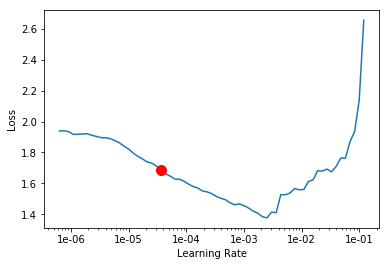

In [23]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.370193,0.338496,0.891950,02:12
1,0.323342,0.305261,0.894812,02:16
2,0.235035,0.302197,0.898151,02:20


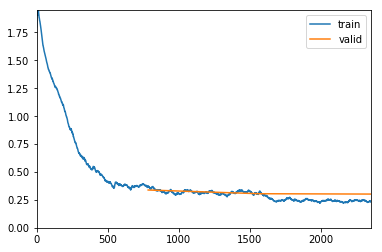

In [24]:
learner.fit_one_cycle(3, max_lr=3e-5)

In [25]:
pred = []
for i in test_df['Description']:
    pred.append(np.argmax(np.array(learner.predict(i)[2])) + 1)
    

In [26]:
print(len(pred))
test_df.shape

22360


(22360, 2)

In [27]:
test_df['Category'] = pred
test_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Application/Permit Number,Description,Category
0,6425384,"Construct 6' retaining wall to create walkway,...",1
1,6496502,Like for like repair of framing at porches of ...,1
2,6622347,Demolish existing single family dwelling. Subj...,1
3,6565685,Establish use as rowhouse and construct new du...,1
4,6487370,Tenant improvement to existing women's boutiqu...,2


In [28]:
category = {
        1: 'SINGLE FAMILY / DUPLEX',
        2: 'COMMERCIAL',
        3: 'MULTIFAMILY',
        4: 'INSTITUTIONAL',
        5: 'INDUSTRIAL'
    }
predict = test_df['Category'].apply(lambda a: category[a])

In [29]:
permit_no = test_df['Application/Permit Number']

submission = pd.DataFrame(
    {'Application/Permit Number': permit_no,
     'Category': predict
    })
submission.to_csv('submission.csv',index=False)

In [30]:
submission.head()

,Application/Permit Number,Category
0,6425384,SINGLE FAMILY / DUPLEX
1,6496502,SINGLE FAMILY / DUPLEX
2,6622347,SINGLE FAMILY / DUPLEX
3,6565685,SINGLE FAMILY / DUPLEX
4,6487370,COMMERCIAL


In [31]:
## To download the submission file without Commiting the kernel.

from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "bert_submission_3.2_epoch.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(submission)